In [1]:
import pandas as pd
import numpy as np
url="https://datafaculty.s3.us-east-2.amazonaws.com/bootcamp/airpassengers.csv"

In [2]:
air=pd.read_csv(url)
air.head(2)

,AirPassengers
0,112
1,118


In [3]:
air.shape

(144, 1)

In [4]:
#### Jan 1949
air['Time']=pd.date_range(start="1949-01",periods=144,freq="M")

In [5]:
air.head(5)

,AirPassengers,Time
0,112,1949-01-31
1,118,1949-02-28
2,132,1949-03-31
3,129,1949-04-30
4,121,1949-05-31


In [19]:
import plotly.express as px
px.line(x=air['Time'],y=air['AirPassengers'])

In [8]:
#### Train and test/validation set
air['Time'].describe()

count                     144
unique                    144
top       1960-07-31 00:00:00
freq                        1
first     1949-01-31 00:00:00
last      1960-12-31 00:00:00
Name: Time, dtype: object

In [9]:
air['Time'].tail()

139   1960-08-31
140   1960-09-30
141   1960-10-31
142   1960-11-30
143   1960-12-31
Name: Time, dtype: datetime64[ns]

In [10]:
### 1 year of data as my test/validation set
train=air[air['Time']<"1960-01-01"]

In [11]:
train.tail()

,AirPassengers,Time
127,559,1959-08-31
128,463,1959-09-30
129,407,1959-10-31
130,362,1959-11-30
131,405,1959-12-31


In [12]:
test=air.drop(train.index)### dropping the rows 

In [13]:
test.head(5)

,AirPassengers,Time
132,417,1960-01-31
133,391,1960-02-29
134,419,1960-03-31
135,461,1960-04-30
136,472,1960-05-31


In [14]:
test

,AirPassengers,Time
132,417,1960-01-31
133,391,1960-02-29
134,419,1960-03-31
135,461,1960-04-30
136,472,1960-05-31
137,535,1960-06-30
138,622,1960-07-31
139,606,1960-08-31
140,508,1960-09-30
141,461,1960-10-31


In [15]:
train.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            122, 123, 124, 125, 126, 127, 128, 129, 130, 131],
           dtype='int64', length=132)

In [16]:
air.index

RangeIndex(start=0, stop=144, step=1)

In [17]:
### Don't forecast for 3-4 time periods
### Modelling:
### Holt Winter's model (Trend,Trend+Seasonality
## - Just models for trend
## - Just models for trend+seasonlality (additive)
## - Just models for trend+seasonaliy (mul)

In [18]:
import statsmodels.tsa.api as smt

In [20]:
### Capture only trend
mod1=smt.ExponentialSmoothing(train['AirPassengers'],trend="add",seasonal=None).fit()

In [22]:
mod1.aic ###

915.707855470897

In [24]:
train.isnull().sum()

AirPassengers    0
Time             0
dtype: int64

In [26]:
import statsmodels

In [27]:
print(statsmodels.__version__)

0.11.1


In [33]:
preds1=mod1.forecast(steps=12)

In [29]:
mod1.predict(start=132,end=143) ### Predictions on the test time frame

132    407.236622
133    409.473244
134    411.709865
135    413.946487
136    416.183109
137    418.419731
138    420.656352
139    422.892974
140    425.129596
141    427.366218
142    429.602839
143    431.839461
dtype: float64

In [34]:
#### Plot actual and predicted values
fig=px.line(x=test['Time'],y=test['AirPassengers'])
fig.add_scatter(x=test['Time'],y=preds1,name="predictions_trend")
fig.show()

In [36]:
### Capture trend+seasonality (add)
mod2=smt.ExponentialSmoothing(train['AirPassengers'],trend="add",seasonal="add",seasonal_periods=12).fit()

/Users/gunnvantsaini/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [37]:
preds2=mod2.forecast(steps=12)

In [38]:
fig=px.line(x=test['Time'],y=test['AirPassengers'])
fig.add_scatter(x=test['Time'],y=preds1,name="predictions_trend")
fig.add_scatter(x=test['Time'],y=preds2,name="predictions_seasonal_add")
fig.show()

In [39]:
mod3=smt.ExponentialSmoothing(train['AirPassengers'],trend="add",seasonal="mul",seasonal_periods=12).fit()

/Users/gunnvantsaini/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [40]:
preds3=mod3.forecast(steps=12)

In [41]:
fig=px.line(x=test['Time'],y=test['AirPassengers'])
fig.add_scatter(x=test['Time'],y=preds1,name="predictions_trend")
fig.add_scatter(x=test['Time'],y=preds2,name="predictions_seasonal_add")
fig.add_scatter(x=test['Time'],y=preds3,name="predictions_seasonal_mul")
fig.show()

In [42]:
#### aic values of models
mod2.aic

684.9657457167199

In [43]:
mod3.aic ### AIC values, prefer lower AIC value () ### AIC values give you error on the training set

642.0682618717118

In [44]:
#### Compute error on out-sample data
### mae
def mae(preds,act):
    return (preds-act).abs().mean()

In [45]:
mae(preds2,test['AirPassengers']) ### Additive Seasonality

10.455564897828168

In [46]:
mae(preds3,test['AirPassengers']) #### Multiplicative model

11.288272571871564

In [47]:
def rmse(preds,act):
    e=(preds-act)
    e=e**2
    e=e.mean()
    return np.sqrt(e)

In [48]:
rmse(preds2,test['AirPassengers']) ## add

15.570830855326424

In [49]:
rmse(preds3,test['AirPassengers']) ## mul

17.485688894193892

In [50]:
def mape(preds,act):
    e=preds-act
    p=(e/act)*100
    return p.abs().mean()

In [51]:
mape(preds2,test['AirPassengers']) ## add

2.3171984287382057

In [52]:
mape(preds3,test['AirPassengers']) ## mul

2.3785872411980287

In [53]:
#### AIC for mul model was better
#### Outsample model performance using MAPE for both Add and Mul is similar

In [54]:
### Business KPI ### Classifying customer good and bad credit card company
### Use the model what business benifit do I get?

In [55]:
### Forecast resource usage: Excel templates

In [56]:
url="https://datafaculty.s3.us-east-2.amazonaws.com/bootcamp/barley.csv"

In [57]:
data=pd.read_csv(url)

In [58]:
data.head(2)

,Year,Annual barley yields per acre in England & Wales 1884 ? 1939
0,1884,15.2
1,1885,16.9


In [59]:
data.isnull().sum()

Year                                                            0
Annual barley yields per acre in England & Wales 1884 ? 1939    1
dtype: int64

In [60]:
data=data.dropna()

In [61]:
data.columns=['Year',"Production"]

In [63]:
px.line(x=data['Year'],y=data['Production']) ### Stationary

In [64]:
### ARIMA models (Don't forecast for long durations, 1-2 time periods)
## AR model 
## xt=b0+b1xt_1+b2xt-2+b3xt_3+...+bnxt_n ### how long this relationship is
## MA model
## xt=b0+b1et_1+b1et_2+....
### ARIMA
## xt=b0+b1xt_1+b2xt-2+b3xt_3+...+bnxt_n+b1et_1+b1et_2+....
## p= how long is the AR relationship 
## q= how long is the MA relationship
## p=?, q=?

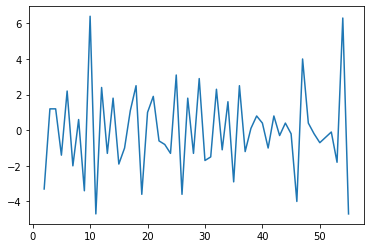

In [67]:
## Make my data stationary
data['Production'].diff().dropna().plot()

In [72]:
### Already stationary so no need to do diff in the data
## by creating acf and pacf plots
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline

[]

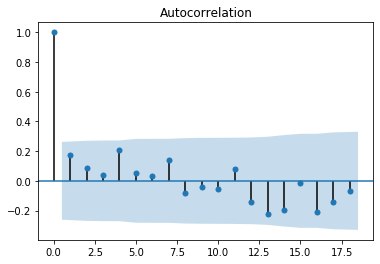

In [73]:
statsmodels.graphics.tsaplots.plot_acf(data['Production'])
plt.plot()

[]

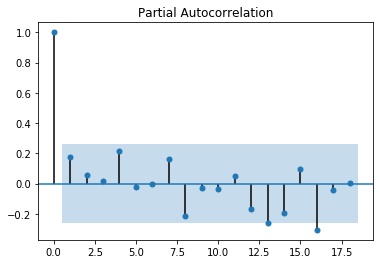

In [74]:
statsmodels.graphics.tsaplots.plot_pacf(data['Production'])
plt.plot()

[]

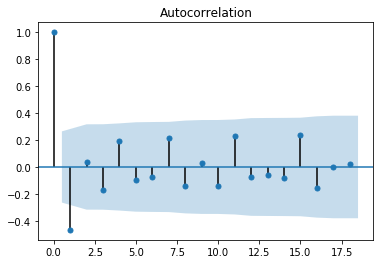

In [75]:
##### Value of P and Q
#### AR or MA component in our model
statsmodels.graphics.tsaplots.plot_acf(data['Production'].diff().dropna())
plt.plot()

[]

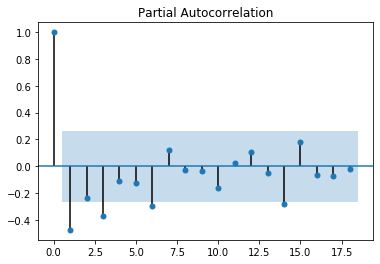

In [76]:
statsmodels.graphics.tsaplots.plot_pacf(data['Production'].diff().dropna())
plt.plot()

In [77]:
### If the values in pacf reduce slowly or they show a sine wave, it means your model has ma terms
### the value of q is non zero
### q=1/2

In [89]:
mod1_arima=smt.ARIMA(data['Production'],order=(0,1,1)).fit() ### p=0,d=1,q=1

In [90]:
print(mod1_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.Production   No. Observations:                   55
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -83.700
Method:                       css-mle   S.D. of innovations              1.098
Date:                Sun, 12 Jul 2020   AIC                            173.400
Time:                        16:06:52   BIC                            179.422
Sample:                             1   HQIC                           175.729
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0170      0.031      0.546      0.585      -0.044       0.078
ma.L1.D.Production    -0.8076      0.097     -8.338      0.000      -0.997      -0.618
                    

[]

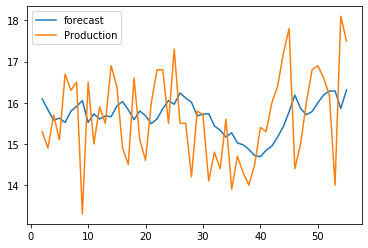

In [93]:
mod1_arima.plot_predict(dynamic=False)
plt.plot()

In [95]:
fc,se,conf=mod1_arima.forecast(3) ### forecast, standard errror (std of values) , confidence interval (95%)

In [78]:
url="https://datafaculty.s3.us-east-2.amazonaws.com/bootcamp/kings.txt"

In [81]:
kings=pd.read_csv(url,header=None)

In [83]:
kings.head(2)

,0
0,60
1,43


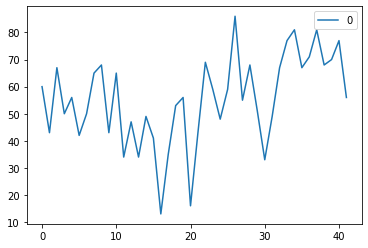

In [84]:
kings.plot()

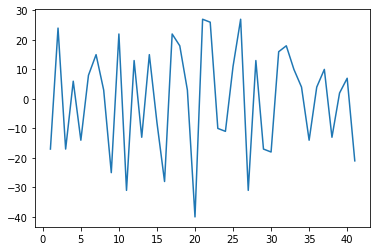

In [86]:
kings[0].diff().dropna().plot()

[]

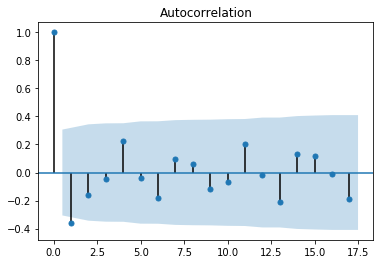

In [87]:
###ACF and pacf
statsmodels.graphics.tsaplots.plot_acf(kings[0].diff().dropna())
plt.plot()

[]

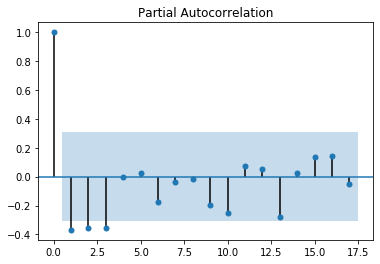

In [88]:
statsmodels.graphics.tsaplots.plot_pacf(kings[0].diff().dropna())
plt.plot()

In [ ]:
##P is non zero
#p=3